# Demo program for calculating efficiency and transmission functions for thermal baths

The purpose of this notebook is to try and calculate the efficiency and power outputs for a two terminal system coupled to thermal baths. The asssumption is that the right bath (R) is colder than the left bath (L), and has a higher electrochemical potential. We are limiting to heat engines, thus we should get a heat and electric current flow from L to R which generates power. Since the process is governed by the temperature and potential bias, the corresponding quantities for L and R are expressed in terms of the biases and the reference, where the temperature and potential at R are references.

$$
\Delta T = T_L - T_R \geq 0 \implies T_R = T, \: T_L = T +  \Delta T \\
\Delta \mu = \mu_L - \mu_R \leq 0 \implies \mu_R = \mu, \: \mu_L = \mu + \Delta \mu
$$

In addition, the reference potential is set to zero, while the temperature is measured after absolute zero. By default, $h = e = 1$, while $k_B$ has units meV/K. Note that we also assume $V = \mu$ with positive $e$, letting the voltage and potential bias have the same sign. One can just multiply the electric current and the bias by minus one if necessary, but here we are considering particle flow, not charge flow. As such, a negative current means that electrons are **leaving** the corresponding bath, which means that the charge current is positive. 

## Transmission function

The core task of this demo is to adapt the transmission function to maximize power or efficiency with regards to a given efficiency or power respectively. For exchange between two thermal baths, it is well known that the ideal transmission function is a band pass, which simply lets through electrons between two energies, $E_0$ and $E_1$, while blocking all others. The balance between power output and efficiency is encoded in the width of the band pass. For a function that tends to the delta function around the exchange energy, 

$$
E^* = \frac{T_L \mu_R - T_R \mu_L}{T_L - T_R},
$$

the efficiency tends to Carnot efficieny. Conversely, a band pass where $E_0 = E^*$ and $E_1$ tends to infinity maximizes power output at the cost of efficieny (but the efficiency does not necessarily tend to zero!). This is highly reasonable, since this allows for all energies at which more electrons leave L than arrive from R according to their Fermi distributions.

While it is possible to simply maximize the power output, maximizing the efficieny without consideration of the power gives a poorly defined problem, since the power output tends to zero when the efficiency tends to Carnot efficieny, equivalently to a reversible process (at least this seems true for this thermal setup). While the program tends to give the correct function, a delta function centered at the exchange energy, the actual value of the efficiency fluctuates highly, as the power output fluctuates around zero, between positive and negative.

## Thermodynamic laws check

It is important to check that the first and second thermodynamic laws are fulfilled to assure numerical stability.


In [34]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.optimize import minimize

In [35]:
# Global constants
h = 1#6.6260688e-34 #J/s
e = 1#1.60227646e-19 #C
kb = 8.617342e-2#meV/K 1.380650e-23 #J/K
optim= True

In [36]:
#Define global ranges and constants
mu = 0
T = 100
r_deltamu = np.flip(np.linspace(-99, 0,100))
r_deltaT = np.linspace(0,99, 100)
E0_set = 0; E1_set = 100
#r_E = np.linspace(E0,E1,100)
print(kb*T)
#print(np.sum(r_E - r_deltamu, axis = 1))

8.617342


In [37]:
#Define functions
def fermi_dist(E, mu, T):
    f_dist = 1/(1+np.exp((E-mu)/(T*kb)))
    return f_dist
def current_integral(E0, E1, muL, TL, muR, TR, transf, occupf = fermi_dist, type = "electric"):
    if type == "electric":
        coeff = lambda E: e
    elif type == "heat":
        coeff = lambda E: (E-muL)
    elif type == "heatR":
        coeff = lambda E: (E-muR)
    elif type == "energy":
        coeff = lambda E: E
    else:
        print("Invalid current type")
        return -1
    if type == "heatR":
        integrand = lambda E: 1/h*coeff(E)*transf(E)*(-occupf(E,muL,TL)+ occupf(E,muR,TR))
    else:    
        integrand = lambda E: 1/h*coeff(E)*transf(E)*(occupf(E,muL,TL)- occupf(E,muR,TR))
    
    # If we have a delta function?
    #if E1 - E0 < 1:
    #    return integrand((E0+E1)/2)*(E0+E1)/2

    current, err = integrate.quad(integrand, E0, E1, args=())
    return current

def simple_current(E0,E1, deltamu, deltaT, type = "electric", N=1):
    def transf(E):
        #return N*(np.heaviside(E-E0,1)*np.heaviside(E1-E,1))
        return N
    return current_integral(E0,E1, deltamu+mu, deltaT+T, mu, T, transf, type = type)

def w_simple_current(E, deltamu, deltaT, type = "electric", N=1):
    return simple_current(E[0],E[1], deltamu, deltaT, type = type, N=1)

def f_maximize_power(E, deltamu, deltaT):
    electric = w_simple_current(E, deltamu, deltaT, type = "electric")
    power = -e*deltamu*electric
    return -power

def f_maximize_eff(E, deltamu, deltaT):
    electric = w_simple_current(E, deltamu, deltaT, type = "electric")
    heat = w_simple_current(E, deltamu, deltaT, type = "heat")
    power = -deltamu*electric
    #if heat == 0:
    #    return np.inf
    eff = power/heat
    #if np.abs(eff) > 1:
    #    return np.inf
    return -eff

# To make sure that we are in the heat engine regime (optimizing gets weird otherwise.)
# However this constraint seems to lead to a badly behaved problem. It could be better/easier to filter the output data afterwards to remove the results where power < 0
def eff_limit(E, deltamu, deltaT):
    electric = w_simple_current(E, deltamu, deltaT, type = "electric")
    heat = w_simple_current(E, deltamu, deltaT, type = "heat")
    power = -deltamu*electric
    
    #if power < 0:
    #    return -1
    #if np.abs(power) < 1e-10:
    #    return -1

    eff = power/np.abs(heat) if heat != 0 else -1
    return (1-T/(deltaT+T)) - eff if eff > 0 else eff
    
def E_max(deltamu, deltaT):
    if deltaT == 0:
        return 0
    #print(((deltaT+T)*mu - T*(deltamu+mu))/deltaT)
    return ((deltaT+T)*mu - T*(deltamu+mu))/deltaT


In [38]:
#Calculate the currents and check that the 1st law is fulfilled (two terminals: left current = - right current)
if optim:
    r_electric = []
    r_energy = []
    r_heat = []
    r_heatR = []
    for deltaT in r_deltaT:
        tmp_electric = []
        tmp_heat = []
        tmp_energy = []
        tmp_heatR = []
        for deltamu in r_deltamu:
            #TODO Much more effective maximizing function
            res = minimize(f_maximize_power, [0.5*E_max(deltamu, deltaT),1.5*E_max(deltamu, deltaT)], args = (deltamu, deltaT), 
                        constraints= [{'type':'ineq', 'fun': lambda E: E[1] - E[0]}]).x
                                        #{'type':'ineq', 'fun': eff_limit, 'args': (deltamu, deltaT)}]).x#, bounds = ((E0, E0), (E1,20000))).x
            #print(E_max(deltamu, deltaT, mu, T))
            #print(res)
            tmp_electric.append(w_simple_current(res, deltamu, deltaT, type = "electric"))
            tmp_energy.append(w_simple_current(res, deltamu, deltaT, type = "energy"))
            tmp_heat.append(w_simple_current(res, deltamu, deltaT, type = "heat"))
            tmp_heatR.append(w_simple_current(res, deltamu, deltaT, type = "heatR"))
        r_electric.append(tmp_electric)
        r_energy.append(tmp_energy)
        r_heat.append(tmp_heat)
        r_heatR.append(tmp_heatR)
else:
    # r_energy = np.array([[simple_current(0.8*E_max(deltamu,deltaT,mu,T), 1.2*E_max(deltamu,deltaT,mu,T), deltamu, deltaT , mu, T, type = "energy") for deltamu in r_deltamu] for deltaT in r_deltaT])
    # r_electric = np.array([[simple_current(0.8*E_max(deltamu,deltaT,mu,T), 1.2*E_max(deltamu,deltaT,mu,T), deltamu, deltaT , mu, T, type = "electric") for deltamu in r_deltamu] for deltaT in r_deltaT])
    # r_heat = np.array([[simple_current(0.8*E_max(deltamu,deltaT,mu,T), 1.2*E_max(deltamu,deltaT,mu,T), deltamu, deltaT , mu, T, type = "heat") for deltamu in r_deltamu] for deltaT in r_deltaT])
    # r_heatR = np.array([[simple_current(0.8*E_max(deltamu,deltaT,mu,T), 1.2*E_max(deltamu,deltaT,mu,T), deltamu, deltaT , mu, T, type = "heatR") for deltamu in r_deltamu] for deltaT in r_deltaT])

    r_energy = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "energy") for deltamu in r_deltamu] for deltaT in r_deltaT])
    r_electric = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "electric") for deltamu in r_deltamu] for deltaT in r_deltaT])
    r_heat = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "heat") for deltamu in r_deltamu] for deltaT in r_deltaT])
    r_heatR = np.array([[simple_current(E0_set,E1_set, deltamu, deltaT, type = "heatR") for deltamu in r_deltamu] for deltaT in r_deltaT])

r_electric = np.array(r_electric)
r_energy = np.array(r_energy)
r_heat = np.array(r_heat)
r_heatR = np.array(r_heatR)# print(r_deltamu.shape)
# print(r_electric.shape)
# print(r_heat.shape)
# print(r_heatR.shape)
check = np.any(np.abs(-e*r_deltamu*r_electric - (r_heat + r_heatR)) > 1e-10)
entropy_check = np.any((-r_heat/(T+r_deltaT.reshape(-1,1)) - r_heatR/T) < 0)
#print(np.abs(-r_deltamu*r_electric - (r_heat + r_heatR)))
#print(r_energy - ((r_deltamu+mu)*r_electric + r_heat))
#print(np.any((-r_heat/(T+r_deltaT.reshape(-1,1)) - r_heatR/T) < 0))
print(f"Is the energy conserved? {not check}")
print(f"Is entropy increasing? {not entropy_check}")



/tmp/ipykernel_57040/315746675.py:4: RuntimeWarning: overflow encountered in exp
  f_dist = 1/(1+np.exp((E-mu)/(T*kb)))


Is the energy conserved? False
Is entropy increasing? True


The generated power is [-0.00000000e+00  5.42799752e+00  9.94366030e+00  1.36336498e+01
  1.65826937e+01  1.88726677e+01  2.05818377e+01  2.17842069e+01
  2.25489886e+01  2.29402014e+01  2.30165036e+01  2.28310547e+01
  2.24315706e+01  2.18604336e+01  2.11549498e+01  2.03475777e+01
  1.94663214e+01  1.85350807e+01  1.75739968e+01  1.65998840e+01
  1.56265570e+01  1.46652190e+01  1.37247864e+01  1.28122041e+01
  1.19327275e+01  1.10901722e+01  1.02871550e+01  9.52528267e+00
  8.80535929e+00  8.12748491e+00  7.49125129e+00  6.89580775e+00
  6.33997975e+00  5.82236472e+00  5.34135477e+00  4.89523426e+00
  4.48222015e+00  4.10048072e+00  3.74818130e+00  3.42350726e+00
  3.12468767e+00  2.84998850e+00  2.59774717e+00  2.36637218e+00
  2.15434421e+00  1.96022191e+00  1.78265295e+00  1.62034770e+00
  1.47211623e+00  1.33683166e+00  1.21344607e+00  1.10098646e+00
  9.98548324e-01  9.05292603e-01  8.20442256e-01  7.43281050e-01
  6.73144503e-01  6.09428597e-01  5.51568497e-01  4.99048894e-01
  

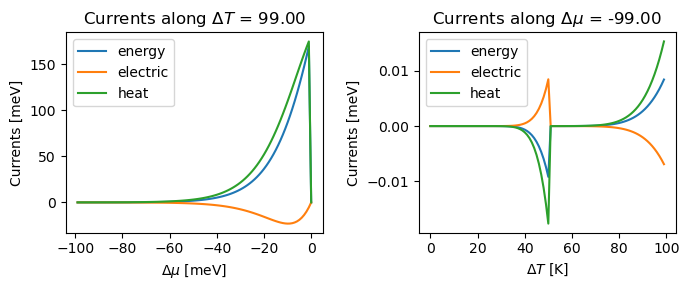

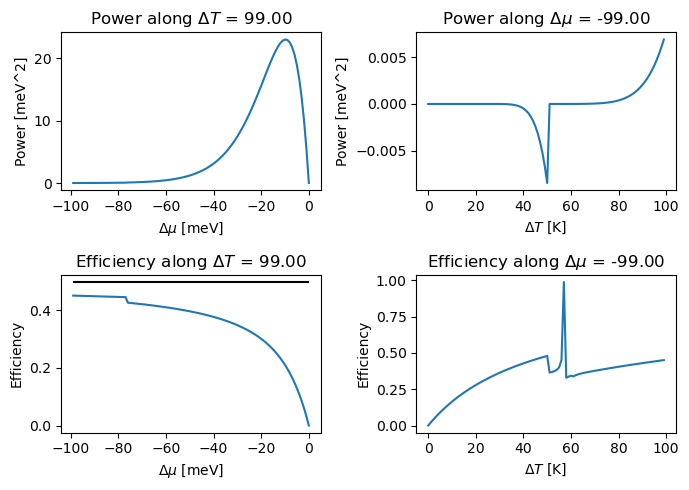

In [39]:
# Plotting power and efficiency
power = -e*r_deltamu*r_electric

#eff = power/r_heat
eff = np.divide(power, r_heat, where = r_heat !=0)
bad_eff = np.where(np.abs(eff) > 1)
#eff[bad_eff] = np.nan
#print(f"The efficiency is {eff}")

#print(r_electric[10,0])
#print(r_heat[10,0])
#print(r_energy[10,0])

T_idx = -1
mu_idx = -1
print(f"The generated power is {power[T_idx,:]}")
print(r_heat[T_idx,:])

#carnot = 

fig, axs = plt.subplots(1,2, figsize=(7,3))
axs[0].set_title(rf"Currents along $\Delta T$ = {r_deltaT[T_idx]:.2f}")
axs[0].plot(r_deltamu, r_energy[T_idx,:], label = "energy")
axs[0].plot(r_deltamu, e*(r_deltamu+mu)*r_electric[T_idx,:], label = "electric")
axs[0].plot(r_deltamu, r_heat[T_idx,:], label = "heat")
axs[0].set_xlabel(rf"$\Delta \mu$ [meV]")
axs[0].set_ylabel(rf"Currents [meV]")
axs[0].legend()
axs[1].set_title(rf"Currents along $\Delta \mu$ = {r_deltamu[mu_idx]:.2f}")
axs[1].plot(r_deltaT, r_energy[:,mu_idx], label = "energy")
axs[1].plot(r_deltaT, e*(r_deltamu[mu_idx]+mu)*r_electric[:, mu_idx], label = "electric")
axs[1].plot(r_deltaT, r_heat[:,mu_idx], label = "heat")
axs[1].set_xlabel(rf"$\Delta T$ [K]")
axs[1].set_ylabel(rf"Currents [meV]")
axs[1].legend()
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(2,2, figsize=(7,5))
axs[0,0].set_title(rf"Power along $\Delta T$ = {r_deltaT[T_idx]:.2f}")
axs[0,0].plot(r_deltamu, (power[T_idx,:]))
axs[0,0].set_xlabel(rf"$\Delta \mu$ [meV]")
axs[0,0].set_ylabel(rf"Power [meV^2]")
axs[0,1].set_title(rf"Power along $\Delta \mu$ = {r_deltamu[mu_idx]:.2f}")
axs[0,1].plot(r_deltaT, power[:,mu_idx])
axs[0,1].set_xlabel(rf"$\Delta T$ [K]")
axs[0,1].set_ylabel(rf"Power [meV^2]")
axs[1,0].set_title(rf"Efficiency along $\Delta T$ = {r_deltaT[T_idx]:.2f}")
axs[1,0].plot(r_deltamu, eff[T_idx,:])
axs[1,0].hlines(1-T/(r_deltaT[T_idx]+T), r_deltamu[0], r_deltamu[-1], colors = 'black')
axs[1,0].set_xlabel(rf"$\Delta \mu$ [meV]")
axs[1,0].set_ylabel(rf"Efficiency")
axs[1,1].set_title(rf"Efficiency along $\Delta \mu$ = {r_deltamu[mu_idx]:.2f}")
axs[1,1].plot(r_deltaT, eff[:,mu_idx])
axs[1,1].set_xlabel(rf"$\Delta T$ [K]")
axs[1,1].set_ylabel(rf"Efficiency")
plt.tight_layout()
plt.show()


In [40]:
# Calculate J_e = 0 curve
Je_zero_idx = []
for i, deltaT in enumerate(r_deltaT):
    flip_idx = np.where(power[i,:-1]*power[i,1:] < 0)[0] + 1
    if flip_idx.size > 0:
        flip_idx=flip_idx[0]
        Je_zero_idx.append(flip_idx if np.abs(power[i,flip_idx]) < power[i,flip_idx-1] else flip_idx-1)
        print(power[i, Je_zero_idx])
    else:
        Je_zero_idx.append(0)
Je_zero = r_electric[:, Je_zero_idx]
print(Je_zero)

[-0.         -0.          0.00040666]
[-0.00000000e+00 -0.00000000e+00  3.10045606e-03  6.42837419e-06]
[-0.00000000e+00 -0.00000000e+00  8.26116173e-03  1.58958524e-04
  1.19115136e-05]
[-0.00000000e+00 -0.00000000e+00  4.03534562e-02  1.04325866e-03
  1.50521280e-04  1.82210981e-06]
[-0.00000000e+00 -0.00000000e+00  6.98083412e-02  3.61807018e-03
  8.02111687e-04  2.72933817e-05 -2.21937051e-08]
[-0.00000000e+00 -0.00000000e+00  1.05214194e-01  8.69013473e-03
  2.63869346e-03  1.64904149e-04  8.04376538e-06 -5.90078271e-07]
[-0.00000000e+00 -0.00000000e+00  1.45195493e-01  1.65989720e-02
  6.39517314e-03  6.32304326e-04  4.88194945e-05  2.90170690e-06
 -1.16593909e-07]
[-0.00000000e+00 -0.00000000e+00  1.88685717e-01  4.81178528e-02
  1.26374105e-02  1.79577934e-03  1.96574896e-04  1.90488989e-05
  5.35955150e-06  1.11170083e-07]
[-0.00000000e+00 -0.00000000e+00  2.34888148e-01  7.83357779e-02
  3.30689642e-02  4.12731315e-03  5.98433061e-04  7.64457297e-05
  2.65577648e-05  2.378787

/tmp/ipykernel_57040/3072341112.py:16: RuntimeWarning: invalid value encountered in divide
  r_S = -r_deltamu[Je_zero_idx]/r_deltaT
/tmp/ipykernel_57040/3072341112.py:21: RuntimeWarning: invalid value encountered in divide
  r_PI = r_heat[0,:]/r_electric[0,:]
/tmp/ipykernel_57040/3072341112.py:22: RuntimeWarning: invalid value encountered in scalar divide
  r_K = [r_heat[i,Je_zero_idx[i]]/r_deltaT[i] for i in range(len(r_deltaT))]


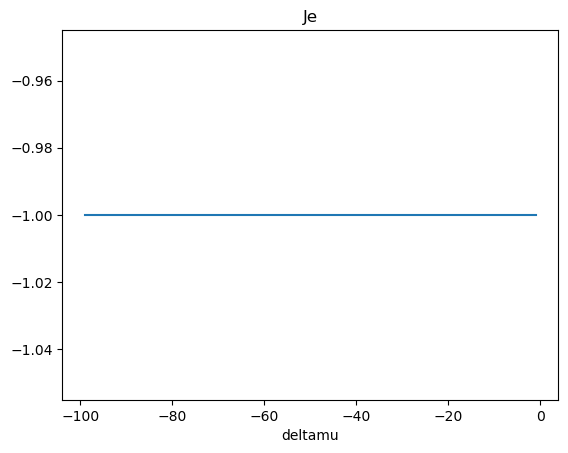

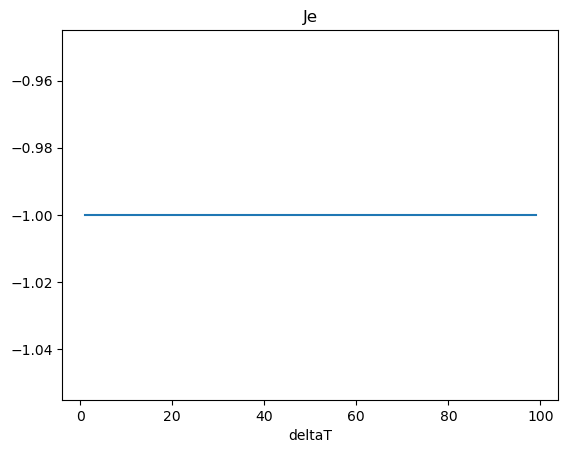

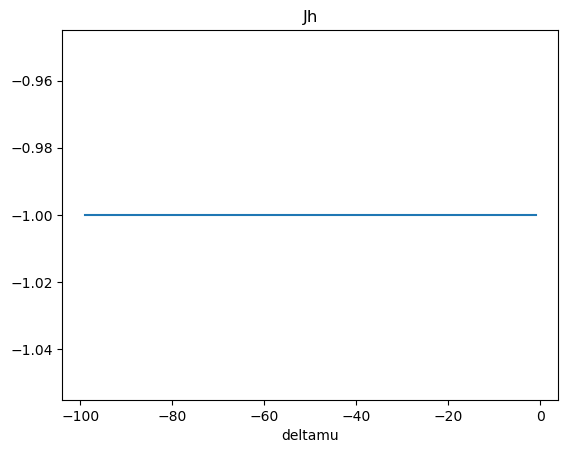

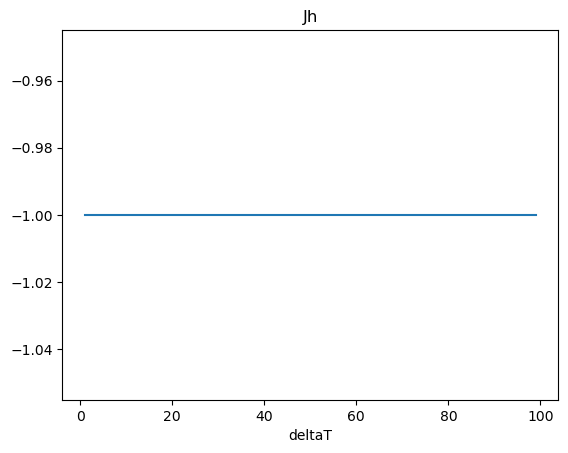

In [41]:
#Time to calculate the transport coefficients and check their asymptotic behaviors!
r_G = r_electric[0,1:]/r_deltamu[1:]
#Divide along the column

r_L = r_heat[0,1:]/r_deltamu[1:]

r_M = r_electric[1:, 0]/r_deltaT[1:]

r_Kplus = r_heat[1:, 0]/r_deltaT[1:]

diff_Je = ((r_G*r_deltamu[1:] + (r_M*r_deltaT[1:]).reshape(-1,1)) - r_electric[1:,1:])/r_electric[1:,1:]
diff_Jh = ((r_L*r_deltamu[1:] + (r_Kplus*r_deltaT[1:]).reshape(-1,1)) - r_heat[1:,1:])/r_heat[1:,1:]
check_Je = np.all(diff_Je < 1e-10)
check_Jh = np.all(diff_Jh < 1e-10)
#r_S = (r_M.reshape(-1,1)/r_G).T
r_S = -r_deltamu[Je_zero_idx]/r_deltaT
#r_K = r_heat[1:,:]/r_deltaT[1:].reshape(-1,1)

#r_S = -(r_deltamu[1:])/r_deltaT[1:].reshape(-1,1)

r_PI = r_heat[0,:]/r_electric[0,:]
r_K = [r_heat[i,Je_zero_idx[i]]/r_deltaT[i] for i in range(len(r_deltaT))]
#r_K = r_Kplus - r_G*r_S*r_PI[1:]

fig = plt.figure()
plt.plot(r_deltamu[1:], diff_Je[0,:])
plt.title("Je")
plt.xlabel("deltamu")
plt.show()
fig = plt.figure()
plt.plot(r_deltaT[1:], diff_Je[:,0])
plt.title("Je")
plt.xlabel("deltaT")
plt.show()
fig = plt.figure()
plt.title("Jh")
plt.plot(r_deltamu[1:], diff_Jh[0,:])
plt.xlabel("deltamu")
plt.show()
fig = plt.figure()
plt.title("Jh")
plt.xlabel("deltaT")
plt.plot(r_deltaT[1:], diff_Jh[:,0])
plt.show()


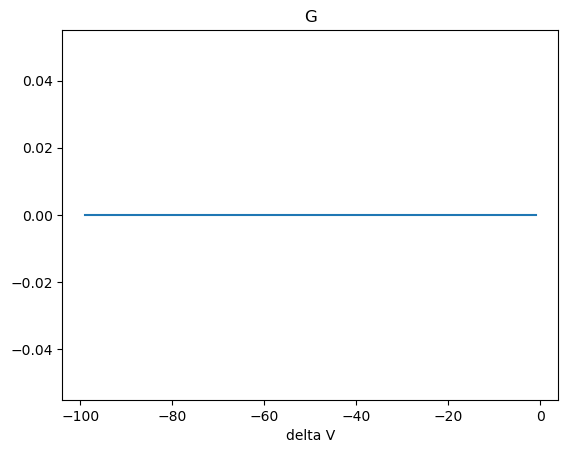

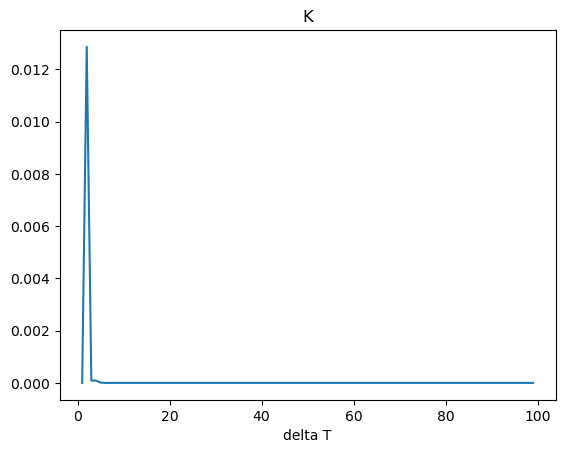

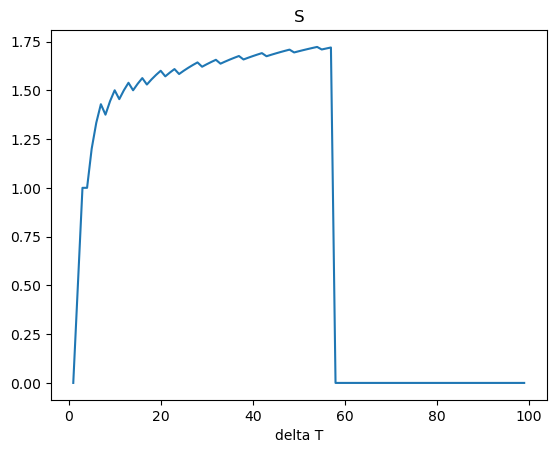

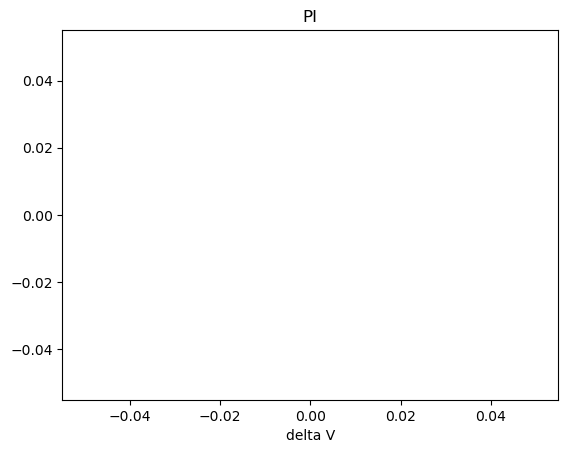

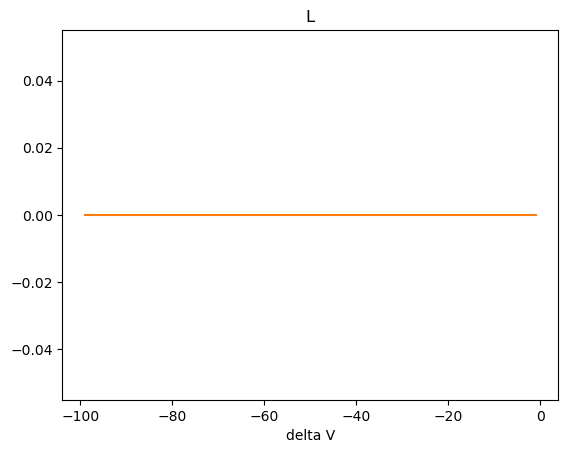

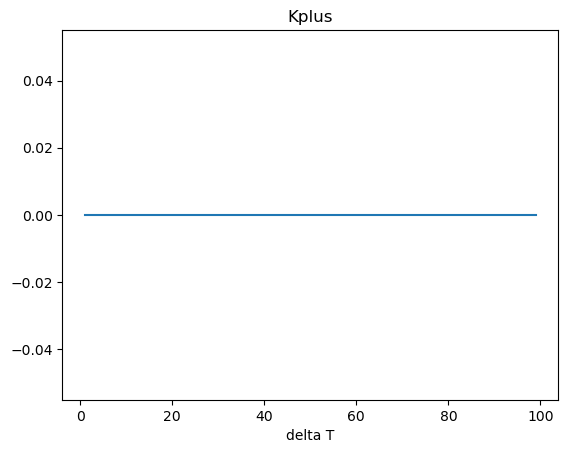

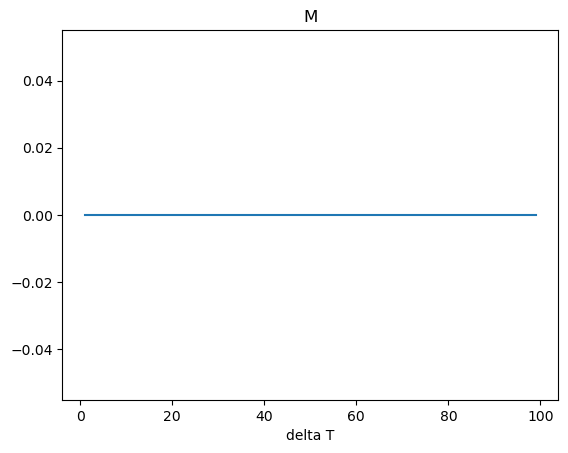

/tmp/ipykernel_57040/1395233957.py:46: RuntimeWarning: invalid value encountered in divide
  plt.plot(r_deltaT[1:], (r_Kplus.reshape(-1,1)/r_G)[:,0])


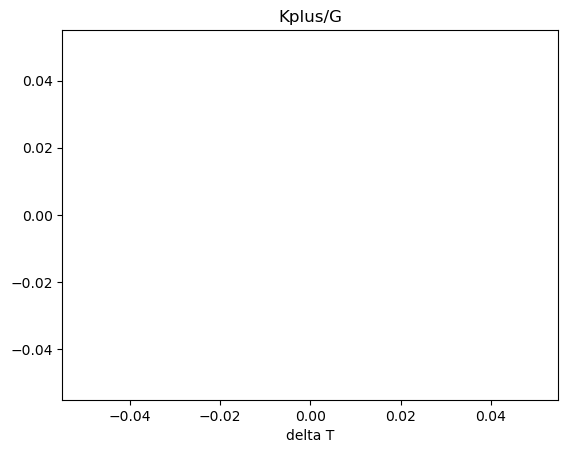

In [42]:
fig = plt.figure()
#plt.plot(r_electric[0,1:], r_G)
plt.plot(r_deltamu[1:], r_G)
plt.title("G")
plt.xlabel("delta V")
plt.show()
fig = plt.figure()
#plt.plot(r_electric[0,1:], r_G)
plt.plot(r_deltaT, r_K) #label = r_deltamu[0:10])
plt.title("K")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT, r_S)#, label = r_deltamu[1:10])
plt.title("S")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltamu, r_PI)
plt.title("PI")
plt.xlabel("delta V")
plt.show()

fig = plt.figure()
plt.plot(r_deltamu[1:], r_PI[1:]*r_G)
plt.plot(r_deltamu[1:], r_L)
plt.title("L")
plt.xlabel("delta V")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT[1:], r_Kplus)
plt.title("Kplus")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT[1:], r_M)
plt.title("M")
plt.xlabel("delta T")
plt.show()

fig = plt.figure()
plt.plot(r_deltaT[1:], (r_Kplus.reshape(-1,1)/r_G)[:,0])
plt.title("Kplus/G")
plt.xlabel("delta T")
plt.show()